# Fourier Transforms
The frequency components of an image can be displayed after doing a Fourier Transform (FT). An FT looks at the components of an image (edges that are high-frequency, and areas of smooth color as low-frequency), and plots the frequencies that occur as points in spectrum.

In fact, an FT treats patterns of intensity in an image as sine waves with a particular frequency, and you can look at an interesting visualization of these sine wave components on [this page](https://plus.maths.org/content/fourier-transforms-images).

In this notebook, a few simple image patterns are considered to build up an idea of what image frequency components look like, and then a more complex image transformations are examined to see how an image can be visualized in the frequency domain.

Fourier Transform is used to analyze the frequency characteristics of various filters. For images, 2D Discrete Fourier Transform (DFT) is used to find the frequency domain. A fast algorithm called Fast Fourier Transform (FFT) is used for calculation of DFT. Details about these can be found in any image processing or signal processing textbooks. Please see [Additional Resources](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html) section.

In [1]:
import numpy as np
from matplotlib import(
    pyplot as plt,
    image as mpim,
)
import cv2 as cv

%matplotlib inline

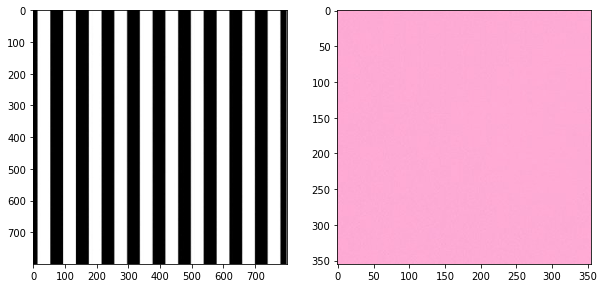

In [2]:
img_stripes = mpim.imread('images/stripes.jpg')
img_solid = mpim.imread('images/pink_solid.jpg')

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img_stripes)
ax2.imshow(img_solid)

plt.show()

## Fourier Transform in Numpy

In [3]:
def fft_img(img):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    norm = np.float32(gray) / 255.0
    
    fft = np.fft.fft2(norm)
    fshift = np.fft.fftshift(fft)
    
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    return magnitude_spectrum

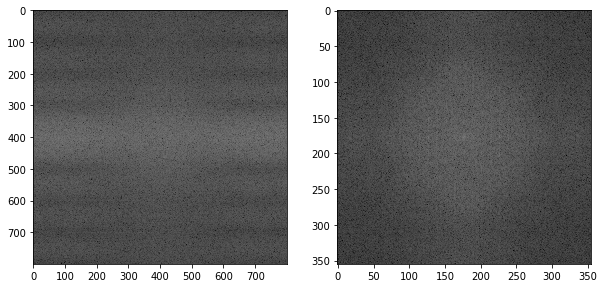

In [4]:
f_stripes = fft_img(img_stripes)
f_solid = fft_img(img_solid)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(f_stripes, cmap='gray')
ax2.imshow(f_solid, cmap='gray')

plt.show()

Low frequencies are at the center of the frequency transform image.

The transform images for these example show that the solid image has most low-frequency components (as seen by the center bright spot).

The stripes tranform image contains low-frequencies for the areas of white and black color and high frequencies for the edges in between those colors. The stripes transform image also tells us that there is one dominating direction for these frequencies; vertical stripes are represented by a horizontal line passing through the center of the frequency transform image.

Next, let's see what this looks like applied to a real-world image.

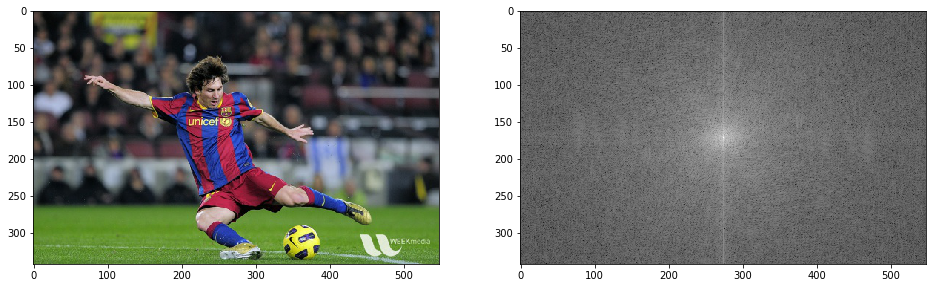

In [5]:
img_messi = mpim.imread('images/messi5.jpg')
fft_messi = fft_img(img_messi)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(img_messi)
ax2.imshow(fft_messi, cmap='gray')

plt.show()

The Fourier transformed image depicts a brighter white region at the center, showing that low frequency content is more dominant in the original image.

## High pass filtering and the inverse Fourier transformation
So, after obtaining the frequency transformation of an image, some additional operations in frequency domain can be considered, like high pass filtering and reconstruction of the image, i.e. finding the inverse DFT. For that, simply remove the low frequencies by masking with a rectangular window of size `60x60`. Then apply the inverse shift using `np.fft.ifftshift()` so that DC component again come at the top-left corner. Then find inverse FFT using `np.ifft2()` function. The result, again, will be a complex number. You can take its absolute value.

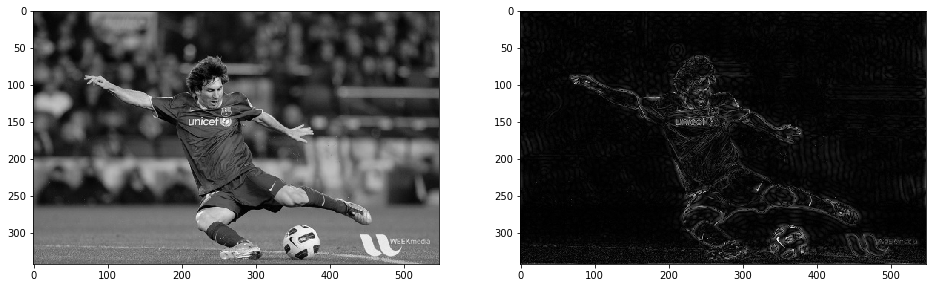

In [6]:
messi_gray = cv.cvtColor(img_messi, cv.COLOR_RGB2GRAY)
messi_norm = np.float32(messi_gray) / 255.0
    
messi_fft = np.fft.fft2(messi_norm)
messi_fshift = np.fft.fftshift(messi_fft)

rows, cols = messi_gray.shape[:2]
crow, ccol = rows // 2, cols // 2
win = 30
messi_fshift[crow-win:crow+win, ccol-win:ccol+win] = 0
messi_ifshift = np.fft.ifftshift(messi_fshift)
messi_back = np.fft.ifft2(messi_ifshift)
messi_back = np.abs(messi_back)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(messi_gray, cmap='gray')
ax2.imshow(messi_back, cmap='gray')

plt.show()

## Inverse Fourier transformation for all RGB channels

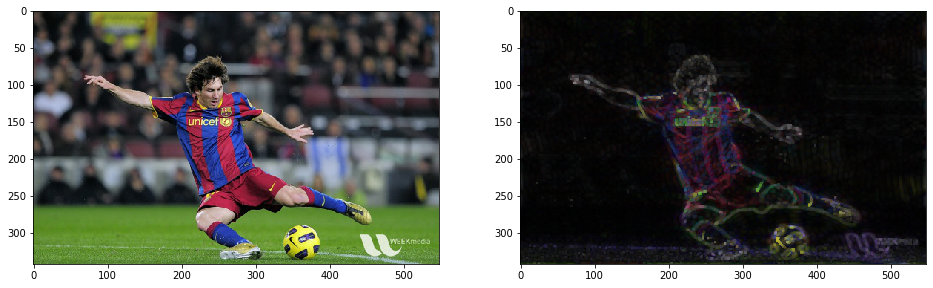

In [7]:
r, g, b = cv.split(img_messi)

r_norm = np.float32(r) / 255.0
g_norm = np.float32(g) / 255.0
b_norm = np.float32(b) / 255.0

r_fft = np.fft.fft2(r_norm)
g_fft = np.fft.fft2(g_norm)
b_fft = np.fft.fft2(b_norm)

r_fshift = np.fft.fftshift(r_fft)
g_fshift = np.fft.fftshift(g_fft)
b_fshift = np.fft.fftshift(b_fft)

rows, cols = r.shape[:2]
crow, ccol = rows // 2, cols // 2
win = 30

r_fshift[crow-win:crow+win, ccol-win:ccol+win] = 0
g_fshift[crow-win:crow+win, ccol-win:ccol+win] = 0
b_fshift[crow-win:crow+win, ccol-win:ccol+win] = 0

r_ifshift = np.fft.ifftshift(r_fshift)
g_ifshift = np.fft.ifftshift(g_fshift)
b_ifshift = np.fft.ifftshift(b_fshift)

r_back = np.fft.ifft2(r_ifshift)
g_back = np.fft.ifft2(g_ifshift)
b_back = np.fft.ifft2(b_ifshift)

r_back = np.abs(r_back)
g_back = np.abs(g_back)
b_back = np.abs(b_back)

kernel = np.ones((3, 3), dtype='uint8')

r_back = cv.dilate(r_back, kernel, iterations=1)
g_back = cv.dilate(g_back, kernel, iterations=1)
b_back = cv.dilate(b_back, kernel, iterations=1)

back = cv.merge([r_back, g_back, b_back])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(img_messi)
ax2.imshow(back)

plt.show()

## Fourier Transform in OpenCV
OpenCV provides the functions `cv2.dft()` and `cv2.idft()` for this. It returns the same result as previous, but with two channels. First channel will have the real part of the result and second channel will have the imaginary part of the result. The input image should be converted to `np.float32` first. We will see how to do it.

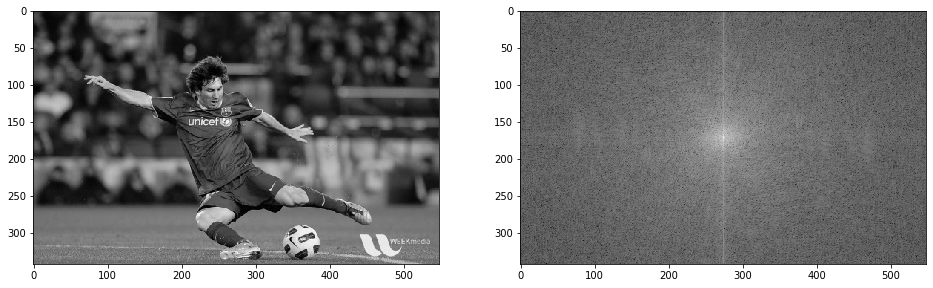

In [8]:
messi_norm = np.float32(messi_gray) / 255.

dft = cv.dft(messi_norm, flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(messi_gray, cmap='gray')
ax2.imshow(magnitude_spectrum, cmap='gray')

plt.show()

## Why Laplacian is a High Pass Filter?
A similar question was asked in a forum. The question is, why Laplacian is a high pass filter? Why Sobel is a HPF? etc. And the first answer given to it was in terms of Fourier Transform. Just take the fourier transform of Laplacian for some higher size of FFT. Analyze it:

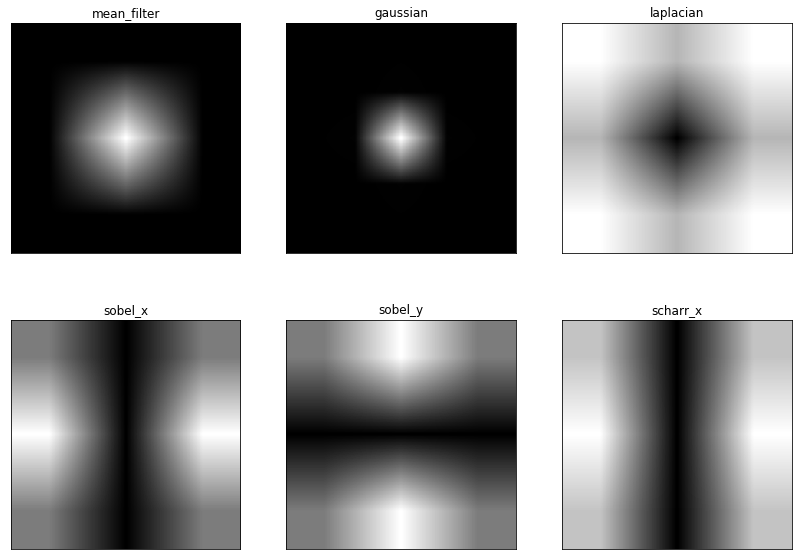

In [30]:
# simple averaging filter with scaling parameter
mean_filter = np.ones((3, 3)) / 9.

# creating a guassian filter
x = cv.getGaussianKernel(ksize=5, sigma=10)
gaussian = x * x.transpose()

# different edge detecting filters
# scharr in x-direction
scharr = np.array([
    [-3, 0, 3],
    [-10,0,10],
    [-3, 0, 3],
])

# sobel in x direction
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])

# sobel in y direction
sobel_y = np.array([
    [-1,-2,-1],
    [0, 0, 0],
    [1, 2, 1],
])

# laplacian
laplacian = np.array([
    [0, 1, 0],
    [1,-4, 1],
    [0, 1, 0]
])

filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = [
    'mean_filter', 
    'gaussian',
    'laplacian', 
    'sobel_x', 
    'sobel_y', 
    'scharr_x'
]

# numpy based DFT
#fft_filters = [np.fft.fft2(x) for x in filters]
#fft_shift = [np.fft.fftshift(y) for y in fft_filters]
#mag_spectrum = [cv.resize(np.log(np.abs(z)+1), (300, 300)) for z in fft_shift]

# opencv based DFT
fft_filters = [cv.dft(np.float32(x), flags=cv.DFT_COMPLEX_OUTPUT) for x in filters]
fft_shift = [np.fft.fftshift(x) for x in fft_filters]
mag_spectrum = [cv.resize(np.log(cv.magnitude(x[:,:,0], x[:,:,1]) + 1), (300, 300)) for x in fft_shift]

_, axi = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))

for i, ax in enumerate(axi.flat):
    ax.imshow(mag_spectrum[i], cmap='gray')
    ax.set_title(filter_name[i])
    ax.set_xticks([]) 
    ax.set_yticks([])

plt.show()

From image, you can see what frequency region each kernel blocks, and what region it passes. From that information, we can say why each kernel is a HPF or a LPF.


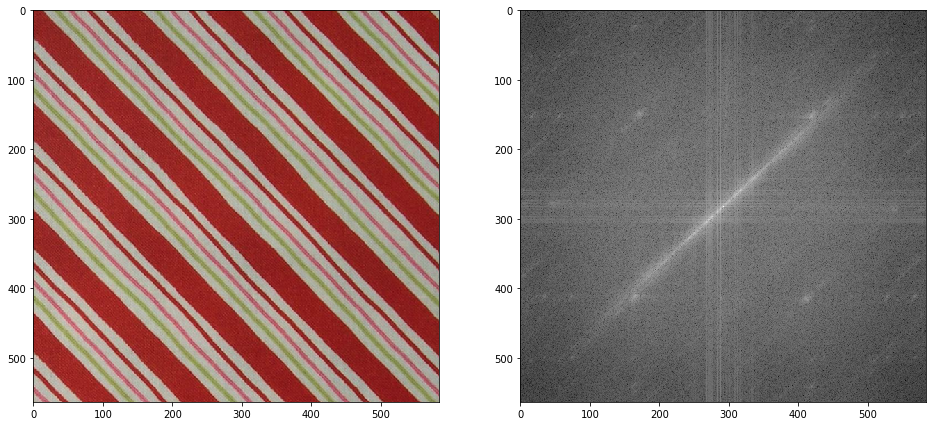

In [36]:
img_diag = mpim.imread('images/diag-stripes.png')
fft_diag = fft_img(img_diag)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(img_diag)
ax2.imshow(fft_diag, cmap='gray')
plt.show()

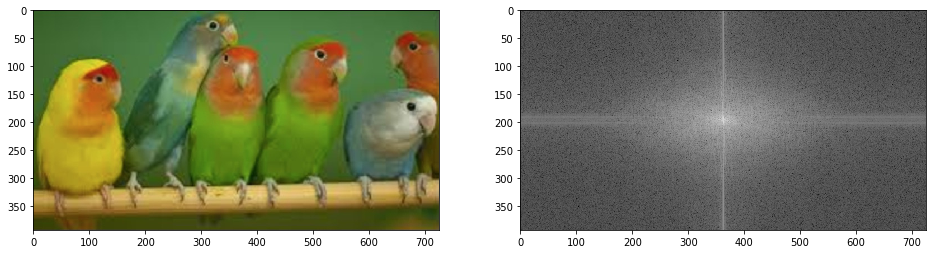

In [37]:
img_birds = mpim.imread('images/birds.jpg')
fft_birds = fft_img(img_birds)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(img_birds)
ax2.imshow(fft_birds, cmap='gray')
plt.show()


Notice that this image has components of all frequencies. You can see a bright spot in the center of the transform image, which tells us that a large portion of the image is low-frequency; this makes sense since the body of the birds and background are solid colors. The transform image also tells us that there are two dominating directions for these frequencies; vertical edges (from the edges of birds) are represented by a horizontal line passing through the center of the frequency transform image, and horizontal edges (from the branch and tops of the birds' heads) are represented by a vertical line passing through the center.